In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
import warnings
warnings.simplefilter("ignore")

In [35]:
df = pd.read_csv(r"data\raw\ChipShot\Jordan\5.csv", header=[3, 4])
df.columns = pd.MultiIndex.from_tuples(
[(c[0].split('(')[0].strip(), c[1].strip()) for c in df.columns])
df

Hamstrings right             Rectus Femoris right             \
     EMG 1 Time Series (s) EMG 1 (mV) EMG 1 Time Series (s) EMG 1 (mV)   
0                 0.000000  -0.012589              0.000000   0.000839   
1                 0.000465  -0.013260              0.000465  -0.000168   
2                 0.000931  -0.023331              0.000931  -0.000839   
3                 0.001397  -0.040620              0.001397  -0.002182   
4                 0.001862  -0.059922              0.001862  -0.005539   
...                    ...        ...                   ...        ...   
6433              2.994672  -0.030716              2.994672   0.017792   
6434              2.995138  -0.029877              2.995138   0.018128   
6435              2.995603  -0.029038              2.995603   0.018631   
6436              2.996069  -0.029709              2.996069   0.018967   
6437              2.996535  -0.029709              2.996535   0.019303   

        Gastrocnemius left            TibilaisÂ Anterior right             \
     EMG 1 Time Series (s) EMG 1 (mV)    EMG 1 Time Series (s) EMG 1 (mV)   
0                 0.000000  -0.024674                 0.000000   0.233814   
1                 0.000465  -0.012253                 0.000465   0.263020   
2                 0.000931   0.000168                 0.000931   0.291218   
3                 0.001397   0.007721                 0.001397   0.317739   
4                 0.001862   0.010575                 0.001862   0.330159   
...                    ...        ...                      ...        ...   
6433              2.994672  -0.026352                 2.994672  -0.015610   
6434              2.995138  -0.026017                 2.995138  -0.015610   
6435              2.995603  -0.026017                 2.995603  -0.016953   
6436              2.996069  -0.026017                 2.996069  -0.016785   
6437              2.996535  -0.026352                 2.996535  -0.012253   

           Hamstrings left            TibilaisÂ Anterior left             \
     EMG 1 Time Series (s) EMG 1 (mV)   EMG 1 Time Series (s) EMG 1 (mV)   
0                 0.000000  -0.006546                0.000000  -0.027695   
1                 0.000465  -0.005539                0.000465  -0.004196   
2                 0.000931  -0.007553                0.000931   0.013931   
3                 0.001397  -0.010239                0.001397   0.005203   
4                 0.001862  -0.013596                0.001862  -0.015274   
...                    ...        ...                     ...        ...   
6433              2.994672  -0.015106                2.994672  -0.017288   
6434              2.995138  -0.016617                2.995138  -0.019303   
6435              2.995603  -0.016617                2.995603  -0.021149   
6436              2.996069  -0.017624                2.996069  -0.021317   
6437              2.996535  -0.018296                2.996535  -0.020981   

       Rectus Femoris left              Gastrocnemius right             
     EMG 1 Time Series (s) EMG 1 (mV) EMG 1 Time Series (s) EMG 1 (mV)  
0                 0.000000  -0.042130              0.000000   0.068315  
1                 0.000465  -0.041291              0.000465   0.064790  
2                 0.000931  -0.038102              0.000931   0.062608  
3                 0.001397  -0.032731              0.001397   0.060258  
4                 0.001862  -0.027695              0.001862   0.057237  
...                    ...        ...                   ...        ...  
6433              2.994672  -0.009567              2.994672  -0.000168  
6434              2.995138  -0.009064              2.995138   0.010910  
6435              2.995603  -0.008225              2.995603   0.022660  
6436              2.996069  -0.009064              2.996069   0.023835  
6437              2.996535  -0.010239              2.996535   0.016785  

[6438 rows x 16 columns]

In [36]:
time_col = df.iloc[:, 0] 
# We extract only the columns containing 'mV' (the EMG data)
emg_data = df.xs('EMG 1 (mV)', level=1, axis=1).copy()
emg_data.insert(0, 'Time', time_col)

In [37]:
emg_data

,Time,Hamstrings right,Rectus Femoris right,Gastrocnemius left,TibilaisÂ Anterior right,Hamstrings left,TibilaisÂ Anterior left,Rectus Femoris left,Gastrocnemius right
0,0.000000,-0.012589,0.000839,-0.024674,0.233814,-0.006546,-0.027695,-0.042130,0.068315
1,0.000465,-0.013260,-0.000168,-0.012253,0.263020,-0.005539,-0.004196,-0.041291,0.064790
2,0.000931,-0.023331,-0.000839,0.000168,0.291218,-0.007553,0.013931,-0.038102,0.062608
3,0.001397,-0.040620,-0.002182,0.007721,0.317739,-0.010239,0.005203,-0.032731,0.060258
4,0.001862,-0.059922,-0.005539,0.010575,0.330159,-0.013596,-0.015274,-0.027695,0.057237
...,...,...,...,...,...,...,...,...,...
6433,2.994672,-0.030716,0.017792,-0.026352,-0.015610,-0.015106,-0.017288,-0.009567,-0.000168
6434,2.995138,-0.029877,0.018128,-0.026017,-0.015610,-0.016617,-0.019303,-0.009064,0.010910
6435,2.995603,-0.029038,0.018631,-0.026017,-0.016953,-0.016617,-0.021149,-0.008225,0.022660
6436,2.996069,-0.029709,0.018967,-0.026017,-0.016785,-0.017624,-0.021317,-0.009064,0.023835


In [38]:
target_order = [
    'Time', 
    'Rectus Femoris right', 'Rectus Femoris left', 
    'Hamstrings right', 'Hamstrings left', 
    'TibilaisÂ Anterior right', 'TibilaisÂ Anterior left', 
    'Gastrocnemius right', 'Gastrocnemius left'
]
emg_data = emg_data.reindex(columns=target_order)
emg_data

,Time,Rectus Femoris right,Rectus Femoris left,Hamstrings right,Hamstrings left,TibilaisÂ Anterior right,TibilaisÂ Anterior left,Gastrocnemius right,Gastrocnemius left
0,0.000000,0.000839,-0.042130,-0.012589,-0.006546,0.233814,-0.027695,0.068315,-0.024674
1,0.000465,-0.000168,-0.041291,-0.013260,-0.005539,0.263020,-0.004196,0.064790,-0.012253
2,0.000931,-0.000839,-0.038102,-0.023331,-0.007553,0.291218,0.013931,0.062608,0.000168
3,0.001397,-0.002182,-0.032731,-0.040620,-0.010239,0.317739,0.005203,0.060258,0.007721
4,0.001862,-0.005539,-0.027695,-0.059922,-0.013596,0.330159,-0.015274,0.057237,0.010575
...,...,...,...,...,...,...,...,...,...
6433,2.994672,0.017792,-0.009567,-0.030716,-0.015106,-0.015610,-0.017288,-0.000168,-0.026352
6434,2.995138,0.018128,-0.009064,-0.029877,-0.016617,-0.015610,-0.019303,0.010910,-0.026017
6435,2.995603,0.018631,-0.008225,-0.029038,-0.016617,-0.016953,-0.021149,0.022660,-0.026017
6436,2.996069,0.018967,-0.009064,-0.029709,-0.017624,-0.016785,-0.021317,0.023835,-0.026017


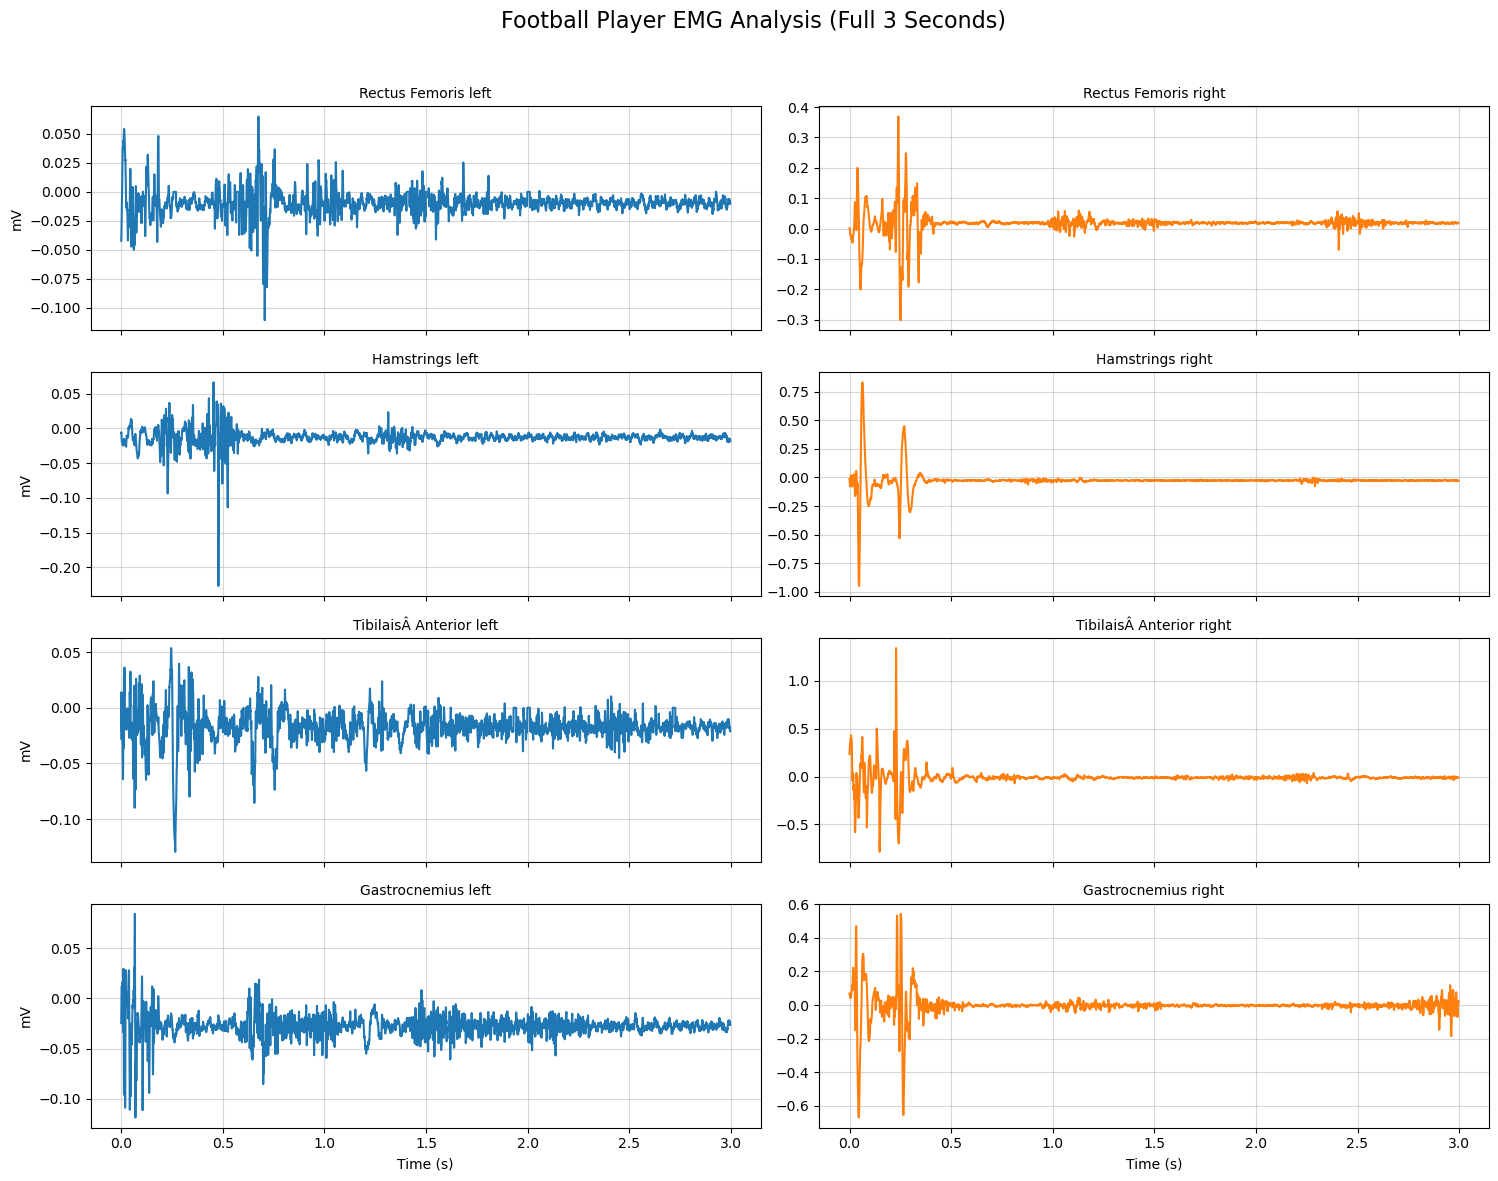

In [39]:
# Initialize the figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig.suptitle('Football Player EMG Analysis (Full 3 Seconds)', fontsize=16)

# Define the list of muscles to look for
muscle_types = ['Rectus Femoris', 'Hamstrings', 'TibilaisÂ Anterior', 'Gastrocnemius']

for i, m_type in enumerate(muscle_types):
    # Dynamic Column Search:
    # Find columns that match the muscle name AND the side (left/right)
    # We filter 'emg_data.columns' to exclude 'Time' so the search doesn't crash
    cols_to_search = [c for c in emg_data.columns if c != 'Time Frame']
    
    # Get the exact column name for the Left and Right version of the current muscle
    left_col = [c for c in cols_to_search if m_type in c and 'left' in c][0]
    right_col = [c for c in cols_to_search if m_type in c and 'right' in c][0]

    # --- Plot Left Leg (Left Column: axis [i, 0]) ---
    axes[i, 0].plot(emg_data['Time'], emg_data[left_col], color='#1f77b4') # Blue color
    axes[i, 0].set_title(left_col, fontsize=10)
    axes[i, 0].grid(True, alpha=0.5)
    axes[i, 0].set_ylabel('mV')

    # --- Plot Right Leg (Right Column: axis [i, 1]) ---
    axes[i, 1].plot(emg_data['Time'], emg_data[right_col], color='#ff7f0e') # Orange color
    axes[i, 1].set_title(right_col, fontsize=10)
    axes[i, 1].grid(True, alpha=0.5)

# Set X-axis labels only on the bottom row
axes[3, 0].set_xlabel('Time (s)')
axes[3, 1].set_xlabel('Time (s)')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
emg_data.to_csv(r"data\processed\ChipShot_Jordan_5.csv", index=False)